### Purpose
This notebook is used to investigate the lower bound of the known records L_min

In [3]:
import pandas as pd
import numpy as np
from numpy import linalg as la
import matplotlib.pyplot as plot
import seaborn as sns
import scipy
import math
#from statsmodels.distributions.empirical_distribution import ECDF
from functools import reduce
from random import sample
# import dill
import os
%matplotlib inline
sns.set(style="ticks")

In [3]:
(25/500000)*100

0.005

In [2]:
# Try to load the internal states (content of variables, etc.) from a previously saved session state
db_name = 'data/partial_view_no_rs.db'
try:
    dill.load_session(db_name) #Comment this line or delete the .db file if you want to start from a fresh state
except FileNotFoundError:
    print('No previous session state saved, skipping...')

No previous session state saved, skipping...


In [3]:
# Helper functions to detect and count known records

def isin_row(df, record, cols=None):
    cols = cols or df.columns
    return reduce(lambda x, y:x&y, [df[f].isin([record[f]]) for f in cols]).any()

def sample_records(df, records_count):
    n = df.shape[0]
    L = records_count
    known_records_indexes = sample(range(n), k=L)
    known_records = df.iloc[known_records_indexes,:]
    return (known_records_indexes, known_records)

def count_present_records(df, known_records):
    records_present = 0
    for i in range(len(known_records)):
        rec = known_records.iloc[i,:]
        if isin_row(df, rec):
            records_present += 1
    return records_present

def count_present_records_distinguish(df, known_records, known_records_indexes):
    records_occurrences = dict([])
    for i in range(len(known_records)):
        rec = known_records.iloc[i,:]
        records_occurrences[known_records_indexes[i]] = 0
        if isin_row(df, rec):
            records_occurrences[known_records_indexes[i]] += 1
    return records_occurrences

def check_pass_test(df, known_records):
    for i in range(len(known_records)):
        rec = known_records.iloc[i,:]
        if not isin_row(df, rec):
            return False
    return True

### Lower bound for L
This lower bound arises from the false positives necessary condition $r_0 > 0$.

It is easy to see that $r_0 > 0 \iff P(R_{V,L} = 0) \leq 1-\eta$
so to get the absolute minimum $L$ (to ensure $r_0 >= 1$) we end up with: $$L_{min} = \min \left\{L \in [1,n] : \frac{\prod_{k=0}^{V}(n-k-L)}{\prod_{k=0}^{V}(n-k)} \leq 1-\eta \right\}$$

that is $$L_{min} = \min \left\{L \in [1,n] : \frac{(n-L)(n-1-L)\cdots (n-V+1-L)}{n(n-1)\cdots (n-V+1)} \leq 1-\eta \right\}$$

In [12]:
def get_L_min(r0, n, V, eta):
    '''Calculate minimum L to ensure a given r0'''
    L = 0
    while int(scipy.stats.hypergeom.isf(eta, n, L, V)) < r0:
        L += 1
    return L



In [4]:
def get_P0(n, V, L):
    p0 = 1.0
    for k in range(V): # k = 0,1,2...,V-1
        p0 *= (n-L-k)/(n-k)
    return p0



In [5]:
def get_smallest_L_min(n, V, eta):
    '''Calculate minimum L to ensure r0 >= 1'''
    L = 0
    while get_P0(n, V, L) > 1-eta: # see math justification above
        L += 1
    return L

If the partial view is too small, we end up with $L_{min} > V$, which doesn't seem good...

In [13]:
n = 1000000
eta = 0.99
Vs = [V for V in range(1000, 1000+10000, 1000)]
#r0 = 1
r0s = [1]
Lmins = [[get_L_min(r0, n, V, eta) for V in Vs] for r0 in r0s]
#Lmins = [get_smallest_L_min(n, V, eta) for V in Vs]

In [28]:
n = 1000000
eta = 0.99
V = 10000
Lmins = get_smallest_L_min(n, V, eta)
Lmins

459

In [27]:
n = 500000
eta = 0.99
V = 5000
Lmins = get_smallest_L_min(n, V, eta)
Lmins

459

(459, 0.0459)

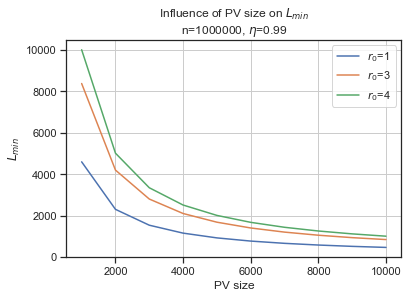

In [16]:
plot.title('Influence of PV size on $L_{min}$\n' + 'n=' + str(n) + ', $\eta$=' + str(eta))
plot.xlabel('PV size')
plot.ylabel('$L_{min}$')
plot.plot(Vs, Lmins[0], Vs, Lmins[1], Vs, Lmins[2])
plot.legend(['$r_0$=' + str(r0s[0]), '$r_0$=' + str(r0s[1]), '$r_0$=' + str(r0s[2])])
plot.grid()
Lmins[0][-1], Lmins[0][-1]/Vs[-1]

In [34]:
Lmins[0][-1]


459

In [17]:
Lmins[1][-1]

838

In [18]:
Lmins[2][-1]

1001

In [15]:
n = 1000000
eta = 0.95
V = 10000
#Vs = [V for V in range(1000, 1000+10000, 1000)]
#r0 = 1
r0s = [1, 2, 3, 4, 5, 6]
#Lmins = [[get_L_min(r0, n, V, eta) for V in Vs] for r0 in r0s]
# Lmins = [get_L_min(r0, n, V, eta) for r0 in r0s]
Lmin_smallest = get_smallest_L_min(n, V, eta)

In [18]:
n = 500000
eta = 0.95
V = 5000
#Vs = [V for V in range(1000, 1000+10000, 1000)]
#r0 = 1
r0s = [1, 2, 3, 4, 5, 6]
#Lmins = [[get_L_min(r0, n, V, eta) for V in Vs] for r0 in r0s]
# Lmins = [get_L_min(r0, n, V, eta) for r0 in r0s]
Lmin_smallest = get_smallest_L_min(n, V, eta)

In [19]:
Lmin_smallest

298

In [6]:
n = 1000000
eta = 0.99
V = 10000
#Vs = [V for V in range(1000, 1000+10000, 1000)]
#r0 = 1
r0s = [1, 2, 3, 4, 5, 6]
#Lmins = [[get_L_min(r0, n, V, eta) for V in Vs] for r0 in r0s]
Lmins = [get_L_min(r0, n, V, eta) for r0 in r0s]
#Lmins = [get_smallest_L_min(n, V, eta) for V in Vs]
Lmins

[459, 661, 838, 1001, 1157, 1307]

In [21]:
n = 1000000
eta = 0.99
Vs = [V for V in range(1000, 1000+10000, 1000)]
#r0 = 1
r0s = [7,8,9,10,11,12]
Lmins = [[get_L_min(r0, n, V, eta) for V in Vs] for r0 in r0s]
#Lmins = [get_smallest_L_min(n, V, eta) for V in Vs]

In [22]:
Lmins


[[14505, 7266, 4846, 3635, 2908, 2423, 2076, 1817, 1614, 1453],
 [15924, 7978, 5321, 3991, 3193, 2661, 2280, 1995, 1773, 1595],
 [17317, 8677, 5788, 4341, 3473, 2894, 2480, 2170, 1928, 1735],
 [18687, 9364, 6246, 4686, 3749, 3124, 2677, 2342, 2081, 1873],
 [20038, 10042, 6699, 5025, 4020, 3350, 2871, 2512, 2232, 2009],
 [21373, 10712, 7146, 5361, 4289, 3574, 3063, 2680, 2382, 2143]]

If we relax the constraint on $V$ and allow up to $\frac{V}{n} \approx 1\%$, then $L_{min}$ becomes reasonably small $\left(\frac{L_{min}}{V} < 5\%\right)$.

(2296842.1052631577, -2.2968421052631576)

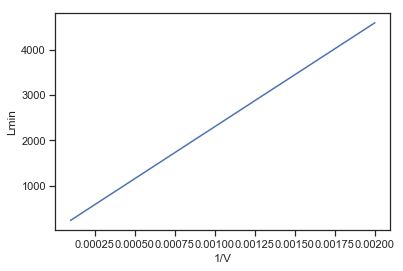

In [54]:
plot.xlabel('1/V')
plot.ylabel('Lmin')
plot.plot([1/V for V in Vs], Lmins[0])
a = (Lmins[0][-1]-Lmins[0][0])/((1/Vs[-1]) - (1/Vs[0]))
b = r0s[0] - (a/n)
a, b

In [28]:
# Save internal state to file
save_state = False
# !!!WARNING!!! This will overwrite the state without asking, uncomment following line if you are sure.
#save_state = True
if save_state:
    del Da # Very big, and deterministic and quick to generate, so we don't save it
    dill.dump_session(db_name)

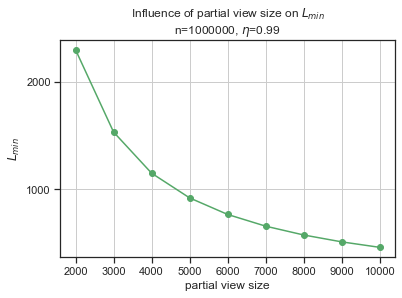

459

In [5]:
Lmins=[[2298, 1532, 1149, 919, 765, 656, 574, 510, 459],
 [3312, 2208, 1656, 1325, 1104, 946, 827, 735, 661],
 [4194, 2796, 2097, 1677, 1398, 1198, 1048, 931, 838],
 [5011, 3341, 2506, 2005, 1670, 1431, 1252, 1113, 1001],
 [5788, 3860, 2895, 2316, 1930, 1654, 1447, 1286, 1157],
 [6537, 4360, 3270, 2616, 2180, 1868, 1634, 1452, 1307], 
 [7266, 4846, 3635, 2908, 2423, 2076, 1817, 1614, 1453],
 [7978, 5321, 3991, 3193, 2661, 2280, 1995, 1773, 1595],
 [8677, 5788, 4341, 3473, 2894, 2480, 2170, 1928, 1735],
 [9364, 6246, 4686, 3749, 3124, 2677, 2342, 2081, 1873],
 [10042, 6699, 5025, 4020, 3350, 2871, 2512, 2232, 2009],
 [10712, 7146, 5361, 4289, 3574, 3063, 2680, 2382, 2143]]

Vs = [2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]
y_stick = [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]

n=1000000
eta=0.99
r0s=[1,2,3,4,5,6,7,8,9,10,11,12]

plot.title('Influence of partial view size on $L_{min}$\n' + 'n=' + str(n) + ', $\eta$=' + str(eta))
plot.xlabel('partial view size')
plot.ylabel('$L_{min}$')
plot.yticks(y_stick, ['1000','2000','3000','4000','5000','6000','7000','8000','9000', '10000'])
# plot.plot(Vs, Lmins[0], Vs, Lmins[2], Vs, Lmins[4])
plot.plot(Vs, Lmins[0],'-go')
# plot.legend(['$r_0$=' + str(r0s[0]), '$r_0$=' + str(r0s[2]), '$r_0$=' + str(r0s[4])])
#plot.plot(Vs, Lmins[0], Vs, Lmins[3], Vs, Lmins[7], Vs, Lmins[10])
#plot.legend(['$r_0$=' + str(r0s[0]), '$r_0$=' + str(r0s[3]), '$r_0$=' + str(r0s[7]), '$r_0$=' + str(r0s[10])])
plot.grid()
plot.savefig('Lmin_r0_1.png', dpi=300, bbox_inches='tight')
plot.show()
Lmins[0][-1]

In [7]:
n = 1000000
eta = 0.95
Vs = [V for V in range(2000, 2000+10000, 2000)]
#r0 = 1
r0s = [1]
Lmins = [[get_L_min(r0, n, V, eta) for V in Vs] for r0 in r0s]
#Lmins = [get_smallest_L_min(n, V, eta) for V in Vs]
Vs, Lmins

([2000, 4000, 6000, 8000, 10000], [[1496, 748, 498, 373, 299]])

In [11]:
n = 1000000
eta = 0.95
Vs = [V for V in range(int(0.005*n), int(n), int(0.005*n))]
#r0 = 1
r0s = [1]
# Lmins = [[get_L_min(r0, n, V, eta) for V in Vs] for r0 in r0s]
Lmins = [get_smallest_L_min(n, V, eta) for V in Vs]
Lmins


KeyboardInterrupt: 

Vs =  [5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000, 45000, 50000, 55000, 60000, 65000, 70000, 75000, 80000, 85000, 90000, 95000, 100000]
Lmins090 = [460, 230, 153, 114, 91, 76, 65, 57, 51, 45, 41, 38, 35, 32, 30, 28, 26, 25, 24, 22]
Lmins095 = [598, 299, 199, 149, 119, 99, 85, 74, 66, 59, 53, 49, 45, 42, 39, 36, 34, 32, 31, 29]
Lmins099 = [919, 459, 305, 228, 182, 152, 130, 113, 101, 90, 82, 75, 69, 64, 60, 56, 52, 49, 47, 44]


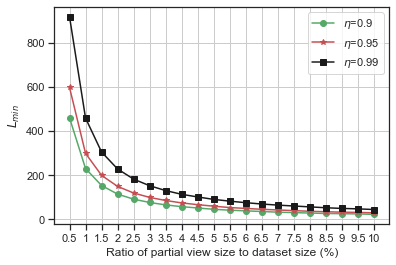

In [31]:
n = 1000000
etas=[0.90, 0.95, 0.99]
# ratios = [ratio for ratio in range(0.005, 0.99, 0.005)]
Vs = [V for V in range(int(0.005*n), int(0.105*n), int(0.005*n))]
#r0 = 1
r0 = 1
print('Vs = ', Vs)    
    
Lmins090 = [get_L_min(r0, n, V, etas[0]) for V in Vs] 
Lmins095 = [get_L_min(r0, n, V, etas[1]) for V in Vs]
Lmins099 = [get_L_min(r0, n, V, etas[2]) for V in Vs] 

#Lmins = [get_smallest_L_min(n, V, eta) for V in Vs]
# Vs[-1], Lmins[-1]

print('Lmins090 =', Lmins090)
print('Lmins095 =', Lmins095)
print('Lmins099 =', Lmins099)
x_stick = [0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6,6.5,7,7.5,8,8.5,9,9.5,10]
# plot.title('Impact of ratio of partial view size to dataset size and $\eta$ on $L_{min}$\n')
plot.xlabel('Ratio of partial view size to dataset size (%)')
plot.ylabel('$L_{min}$')
plot.xticks(x_stick, ['0.5','1','1.5','2','2.5','3','3.5','4','4.5', '5','5.5','6','6.5','7','7.5','8','8.5','9','9.5','10'])
# plot.plot(Vs, Lmins090, '-go', Vs, Lmins095, '-r*',Vs, Lmins099, '-ks')
plot.plot(x_stick, Lmins090, '-go', x_stick, Lmins095, '-r*',x_stick, Lmins099, '-ks')
# plot.plot(ratios, Lmins090, '-go', ratios, Lmins095, '-r*',ratios, Lmins099, '-ks')
plot.legend(['$\eta$=' + str(etas[0]), '$\eta$=' + str(etas[1]), '$\eta$=' + str(etas[2])])
#plot.plot(Vs, Lmins[0], Vs, Lmins[3], Vs, Lmins[7], Vs, Lmins[10])
#plot.legend(['$r_0$=' + str(r0s[0]), '$r_0$=' + str(r0s[3]), '$r_0$=' + str(r0s[7]), '$r_0$=' + str(r0s[10])])
plot.grid()
plot.savefig('Lmin_ratioPV_n_eta_1M.pdf', dpi=300, bbox_inches='tight')
plot.show()




Vs =  [2500, 5000, 7500, 10000, 12500, 15000, 17500, 20000, 22500, 25000, 27500, 30000, 32500, 35000, 37500, 40000, 42500, 45000, 47500, 50000]
Lmins090 = [460, 230, 153, 114, 91, 76, 65, 57, 51, 45, 41, 38, 35, 32, 30, 28, 26, 25, 24, 22]
Lmins095 = [598, 298, 199, 149, 119, 99, 85, 74, 66, 59, 53, 49, 45, 42, 39, 36, 34, 32, 31, 29]
Lmins099 = [918, 459, 305, 228, 182, 152, 130, 113, 101, 90, 82, 75, 69, 64, 60, 56, 52, 49, 47, 44]


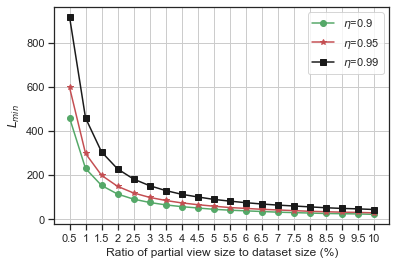

In [30]:
n = 500000
etas=[0.90, 0.95, 0.99]
# ratios = [ratio for ratio in range(0.005, 0.99, 0.005)]
Vs = [V for V in range(int(0.005*n), int(0.105*n), int(0.005*n))]
#r0 = 1
r0 = 1
print('Vs = ', Vs)    
    
Lmins090 = [get_L_min(r0, n, V, etas[0]) for V in Vs] 
Lmins095 = [get_L_min(r0, n, V, etas[1]) for V in Vs]
Lmins099 = [get_L_min(r0, n, V, etas[2]) for V in Vs] 

#Lmins = [get_smallest_L_min(n, V, eta) for V in Vs]
# Vs[-1], Lmins[-1]

print('Lmins090 =', Lmins090)
print('Lmins095 =', Lmins095)
print('Lmins099 =', Lmins099)
x_stick = [0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6,6.5,7,7.5,8,8.5,9,9.5,10]
# plot.title('Impact of ratio of partial view size to dataset size and $\eta$ on $L_{min}$\n')
plot.xlabel('Ratio of partial view size to dataset size (%)')
plot.ylabel('$L_{min}$')
plot.xticks(x_stick, ['0.5','1','1.5','2','2.5','3','3.5','4','4.5', '5','5.5','6','6.5','7','7.5','8','8.5','9','9.5','10'])
# plot.plot(Vs, Lmins090, '-go', Vs, Lmins095, '-r*',Vs, Lmins099, '-ks')
plot.plot(x_stick, Lmins090, '-go', x_stick, Lmins095, '-r*',x_stick, Lmins099, '-ks')
# plot.plot(ratios, Lmins090, '-go', ratios, Lmins095, '-r*',ratios, Lmins099, '-ks')
plot.legend(['$\eta$=' + str(etas[0]), '$\eta$=' + str(etas[1]), '$\eta$=' + str(etas[2])])
#plot.plot(Vs, Lmins[0], Vs, Lmins[3], Vs, Lmins[7], Vs, Lmins[10])
#plot.legend(['$r_0$=' + str(r0s[0]), '$r_0$=' + str(r0s[3]), '$r_0$=' + str(r0s[7]), '$r_0$=' + str(r0s[10])])
plot.grid()
plot.savefig('Lmin_ratioPV_n_eta_500K.pdf', dpi=300, bbox_inches='tight')
plot.show()




Vs =  [4000, 8000, 12000, 16000, 20000, 24000, 28000, 32000, 36000, 40000, 44000, 48000, 52000, 56000, 60000, 64000, 68000, 72000, 76000, 80000]
Lmins090 = [460, 230, 153, 114, 91, 76, 65, 57, 51, 45, 41, 38, 35, 32, 30, 28, 26, 25, 24, 22]
Lmins095 = [598, 299, 199, 149, 119, 99, 85, 74, 66, 59, 53, 49, 45, 42, 39, 36, 34, 32, 31, 29]
Lmins099 = [919, 459, 305, 228, 182, 152, 130, 113, 101, 90, 82, 75, 69, 64, 60, 56, 52, 49, 47, 44]


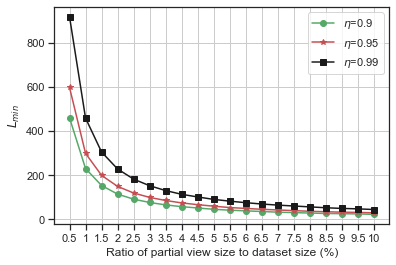

In [32]:
n = 800000
etas=[0.90, 0.95, 0.99]
# ratios = [ratio for ratio in range(0.005, 0.99, 0.005)]
Vs = [V for V in range(int(0.005*n), int(0.105*n), int(0.005*n))]
#r0 = 1
r0 = 1
print('Vs = ', Vs)    
    
Lmins090 = [get_L_min(r0, n, V, etas[0]) for V in Vs] 
Lmins095 = [get_L_min(r0, n, V, etas[1]) for V in Vs]
Lmins099 = [get_L_min(r0, n, V, etas[2]) for V in Vs] 

#Lmins = [get_smallest_L_min(n, V, eta) for V in Vs]
# Vs[-1], Lmins[-1]

print('Lmins090 =', Lmins090)
print('Lmins095 =', Lmins095)
print('Lmins099 =', Lmins099)
x_stick = [0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6,6.5,7,7.5,8,8.5,9,9.5,10]
# plot.title('Impact of ratio of partial view size to dataset size and $\eta$ on $L_{min}$\n')
plot.xlabel('Ratio of partial view size to dataset size (%)')
plot.ylabel('$L_{min}$')
plot.xticks(x_stick, ['0.5','1','1.5','2','2.5','3','3.5','4','4.5', '5','5.5','6','6.5','7','7.5','8','8.5','9','9.5','10'])
# plot.plot(Vs, Lmins090, '-go', Vs, Lmins095, '-r*',Vs, Lmins099, '-ks')
plot.plot(x_stick, Lmins090, '-go', x_stick, Lmins095, '-r*',x_stick, Lmins099, '-ks')
# plot.plot(ratios, Lmins090, '-go', ratios, Lmins095, '-r*',ratios, Lmins099, '-ks')
plot.legend(['$\eta$=' + str(etas[0]), '$\eta$=' + str(etas[1]), '$\eta$=' + str(etas[2])])
#plot.plot(Vs, Lmins[0], Vs, Lmins[3], Vs, Lmins[7], Vs, Lmins[10])
#plot.legend(['$r_0$=' + str(r0s[0]), '$r_0$=' + str(r0s[3]), '$r_0$=' + str(r0s[7]), '$r_0$=' + str(r0s[10])])
plot.grid()
plot.savefig('Lmin_ratioPV_n_eta_800K.pdf', dpi=300, bbox_inches='tight')
plot.show()


